This short example show how to get data from FMI Open Data multipointcoverage format. The format is used in INSPIRE specifications and is somewhat complex. Anyway, it's the most efficient way to get large amounts of data.

Here we fetch all observations from Finland during two days.

This example is for "old" format WFS2. You may try to use new WFS3 beta service as well. It's available in: http://beta.fmi.fi/data/3/wfs/sofp/

In [7]:
import requests
import datetime as dt
import xml.etree.ElementTree as ET
import numpy as np
import re
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colorbar, colors

Required functions to get param names. Param keys are in the response document but longer names along with other metadata need to be fetched separately. 

In [2]:
def get_param_names(url):
    """ Get parameters metadata"""
    req = requests.get(url)
    params = {}
    
    if req.status_code == 200:
        xmlstring = req.content
        tree = ET.ElementTree(ET.fromstring(xmlstring))                
        for p in tree.iter(tag='{http://inspire.ec.europa.eu/schemas/omop/2.9}ObservableProperty'):
            params[p.get('{http://www.opengis.net/gml/3.2}id')] = p.find('{http://inspire.ec.europa.eu/schemas/omop/2.9}label').text
    return params        
    
def get_params(tree):
    """ Get parameters from response xml tree """
    
    retParams = []
    for el in tree.iter(tag='{http://www.opengis.net/om/2.0}observedProperty'):
        url = el.get('{http://www.w3.org/1999/xlink}href')
        params = re.findall(r"(?<=param=).*,.*(?=&)", url)[0].split(',')

        param_names = get_param_names(url)
        for p in params:
            retParams.append('{} ({})'.format(param_names[p], p))
                
    return retParams

Positions are in the separate element. Positions are listed as lat, lon, timestamp. 

In [3]:
def get_positions(tree):
    """ 
    Function to get times and coordinates from multipointcoverage answer
    """
    positions = []
    for el in tree.iter(tag='{http://www.opengis.net/gmlcov/1.0}positions'):
        pos = el.text.split()
        i = 0
        while len(pos) > 0:
            lat = float(pos.pop(0))
            lon = float(pos.pop(0))
            timestamp = int(pos.pop(0))
            positions.append([lat,lon,timestamp])
    return np.array(positions)

Get data. For longer periods we have to fetch data in the loop

In [4]:
url = 'http://opendata.fmi.fi/wfs'
bbox = '19,59,30,75'
data = False

starttime = dt.datetime.strptime('2010-01-01', "%Y-%m-%d")
endtime = dt.datetime.strptime('2010-01-03', "%Y-%m-%d")
daystep = 1

start = starttime
end = start + dt.timedelta(days=daystep)
if end > endtime: end = endtime
    
while end <= endtime and start < end:
    startStr = start.strftime('%Y-%m-%d')
    endStr = end.strftime('%Y-%m-%d')
    
    # Get data
    payload = {
        'request': 'getFeature',
        'storedquery_id': 'fmi::observations::weather::multipointcoverage',
        'bbox': bbox,
        'starttime': startStr,
        'endtime': endStr,    
    }
    r = requests.get(url, params=payload)
    
    # Construct XML tree
    tree = ET.ElementTree(ET.fromstring(r.content))

    # Get geospatial and temporal positions of data elements
    positions = get_positions(tree)
        
    # Extract data from XML tree
    d = []
    for el in tree.iter(tag='{http://www.opengis.net/gml/3.2}doubleOrNilReasonTupleList'):
        for pos in el.text.strip().split("\n"):
            d.append(list(map(float, pos.strip().split(' '))))
    
    # Assign data values to positions
    junk = np.append(positions, np.array(d), axis=1)
    if data is not False:
        data = np.append(data, junk, axis=0)
    else:
        data = junk
    
    print('Time interval {} - {} provided {} rows'.format(startStr, endStr, junk.shape[0]))
    
    start = end
    end = start + dt.timedelta(days=daystep)
    if end > endtime: end = endtime

print('Done fetching data. Final dimensions of the result: {}'.format(data.shape))

Time interval 2010-01-01 - 2010-01-02 provided 22779 rows
Time interval 2010-01-02 - 2010-01-03 provided 22747 rows
Done fetching data. Final dimensions of the result: (45526, 16)


Get params from the last XML tree element (they don't change over time)

In [5]:
params = get_params(tree)

Finally you can do whatever you want with the data. Here we just plot some colored points from few different hours. 

For plotting, we use cartopy. See more for details: https://scitools.org.uk/cartopy/docs/latest/index.html

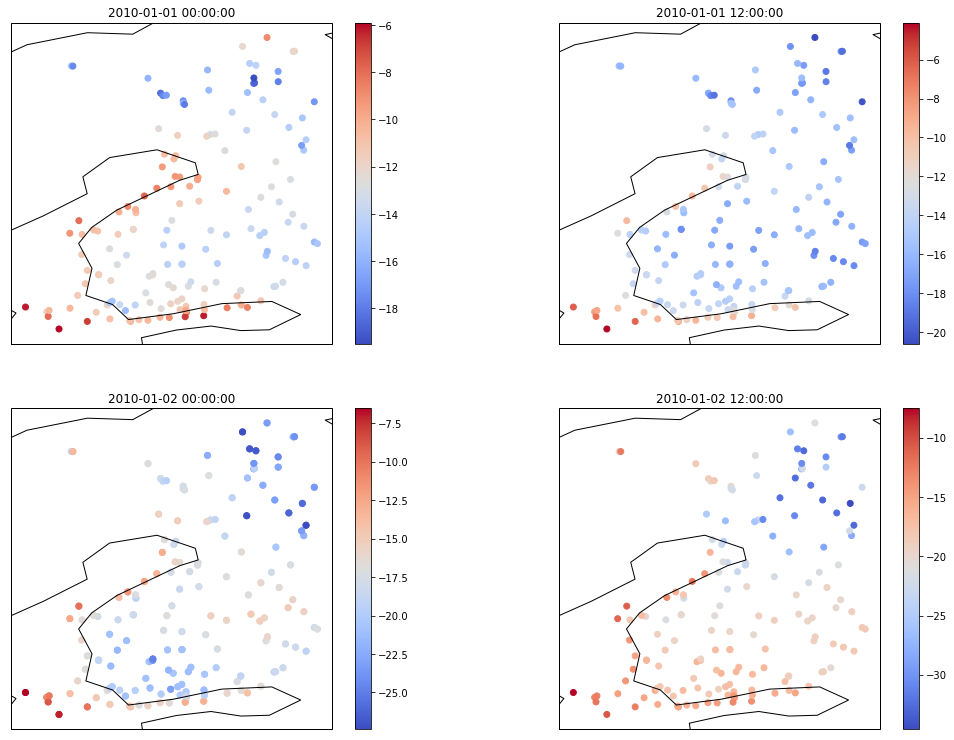

In [6]:
fig = plt.figure(figsize=(18, 13))
first_timestamp = data[0,2]
axes = {}

for i in np.arange(0,4):    
    axes[i] = plt.subplot(2, 2, i+1, projection=ccrs.PlateCarree())
    axes[i].coastlines()

    timestamp = first_timestamp + 12*3600*i
    
    coords = data[(data[:,2] == timestamp)][:,0:2]
    coords = np.column_stack((coords[:,1], coords[:,0]))

    val = data[(data[:,2] == timestamp)][:,3]

    cb = axes[i].scatter(coords[:,0], coords[:,1], c=val, cmap='coolwarm')
    plt.colorbar(cb, cmap='coolwarm', orientation='vertical',ticklocation='auto')
    
    axes[i].set_title('{}'.format(dt.datetime.fromtimestamp(timestamp)))

plt.show()

In [12]:
dates = set()
for timestamp in data[:,2]:
    d = dt.datetime.fromtimestamp(timestamp)
    if d not in dates:
        dates.add(d)
        print(d)
    

2010-01-01 00:00:00
2010-01-01 00:10:00
2010-01-01 00:20:00
2010-01-01 00:30:00
2010-01-01 00:40:00
2010-01-01 00:50:00
2010-01-01 01:00:00
2010-01-01 01:10:00
2010-01-01 01:20:00
2010-01-01 01:30:00
2010-01-01 01:40:00
2010-01-01 01:50:00
2010-01-01 02:00:00
2010-01-01 02:10:00
2010-01-01 02:20:00
2010-01-01 02:30:00
2010-01-01 02:40:00
2010-01-01 02:50:00
2010-01-01 03:00:00
2010-01-01 03:10:00
2010-01-01 03:20:00
2010-01-01 03:30:00
2010-01-01 03:40:00
2010-01-01 03:50:00
2010-01-01 04:00:00
2010-01-01 04:10:00
2010-01-01 04:20:00
2010-01-01 04:30:00
2010-01-01 04:40:00
2010-01-01 04:50:00
2010-01-01 05:00:00
2010-01-01 05:10:00
2010-01-01 05:20:00
2010-01-01 05:30:00
2010-01-01 05:40:00
2010-01-01 05:50:00
2010-01-01 06:00:00
2010-01-01 06:10:00
2010-01-01 06:20:00
2010-01-01 06:30:00
2010-01-01 06:40:00
2010-01-01 06:50:00
2010-01-01 07:00:00
2010-01-01 07:10:00
2010-01-01 07:20:00
2010-01-01 07:30:00
2010-01-01 07:40:00
2010-01-01 07:50:00
2010-01-01 08:00:00
2010-01-01 08:10:00
